# Assignment 11
## 11.0 Introduction
In this assignement, we will try to have an overlook on OpenPose algorithm (https://arxiv.org/pdf/1812.08008.pdf). Instinctively, we could try to recognize human pose by making a network who perform a segmentation on each articulation of human body. Then we would just need to link all the joints toghether to make a digital skeleton, not that simple of course. If their is several persons on the same image for instance, how to link the good neck with the good head???
The idea behind this algorithm is to have to differents maps: a Part Affinity Fields (PAFs) and Part Confidence Maps(PCMs)

In [12]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="https://www.researchgate.net/publication/332669619/figure/fig5/AS:751775762092034@1556248717717/Part-Affinity-Fields-Architecture-Figure-1.ppm")

The network structure is above, branch 1 and 2 are respectively in charge of generating PCM and PAF thru multiple stage to have more accuracy.

In [13]:
Image(url= "https://news.mynavi.jp/article/cv_future-47/index_images/index.jpg")

The first network generating the PCM find each part of the body (elbow, neck, etc... colored points above) and the network generating the PAF is linking the part together (orange field above). Then we apply a greedy/hongarian algorithm to link the part which are most probably join.

## 11.1 Setup the network and modify it.

We will use a pretrain network to do all our work. All the code is in the folder "openpose". You should first of all download the weights of the network, their is two file : "body_pose_model.pth" (199.57Mb) et "hand_pose_model.pth" (140.52Mb) (https://www.dropbox.com/sh/7xbup2qsn7vvjxo/AABWFksdlgOMXR_r5v3RwKRYa?dl=0) and place them into a "model" folder you create. Then the few line beneath should run perfectly.

We want you to get into the code of the network in the folder "openpose/body" and you should modify it to be able to access the PCM and PAF. Remember, like for the segmentation their is as many layer as their is labels. Then you should be able to overlay the original image with one of the map (only one layer of each map)

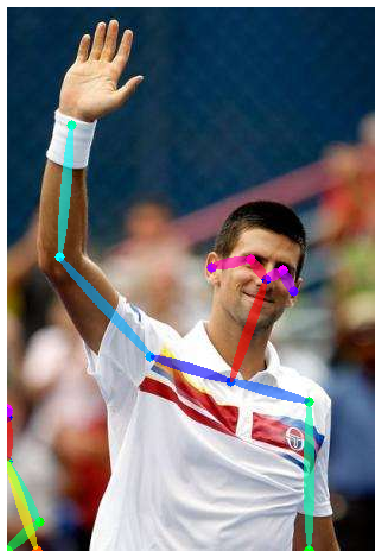

In [1]:
import sys
sys.path.insert(0, 'openpose')
import cv2
import model
import util
from hand import Hand
from body import Body
import matplotlib.pyplot as plt
import copy
import numpy as np
import torch
import glob
import os

body_estimation = Body('model/body_pose_model.pth')
hand_estimation = Hand('model/hand_pose_model.pth')

part={
    "nose":0,
    "neck":1,
    "right_shldr":2,
    "right_elbw":3,
    "right_wrst":4,
    "left_shldr":5,
    "left_elbw":6,
    "left_wrst":7,
    "right_hps":8,
    "right_kn":9,
    "right_nkl":10,
    "left_hps":11,
    "left_kn":12,
    "left_nkl":13,
    "right_eye":14,
    "left_eye":15,
    "right_hear":16,
    "left_hear":17
}

test_image = 'images/demo.jpg'

def estimate_plot(filename):
    objtohighlight = part["neck"]
    oriImg = cv2.imread(filename)  # B,G,R order
    candidate, subset, PCM, PFA = body_estimation(oriImg)
   # print(candidate[:,0:2])
   # print(subset)
    canvas = copy.deepcopy(oriImg)
    canvas = util.draw_bodypose(canvas, candidate, subset)
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas[:, :, [2, 1, 0]])
    plt.axis('off')
    plt.show()
    
estimate_plot(test_image)

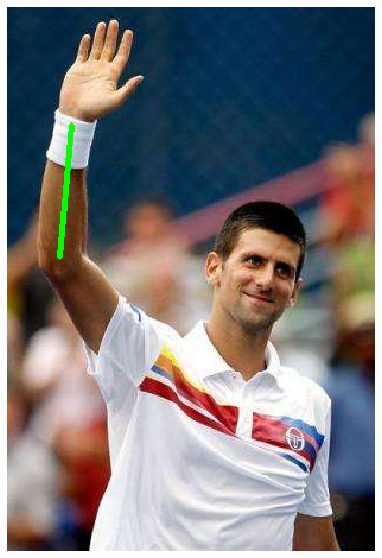

In [59]:
def drawHeat(canvas, p1, p2):
    canvas = cv2.line(canvas, (p1[0], p1[1]), (p2[0], p2[1]), (0,255,0), 4)
    return canvas

def indexRangeOfJoints(pcm, labelIndex):
    i = 0
    u = 0
    startIndex = -1
    endOffset = 0
    started = 0
    for item in pcm:
        if(u == labelIndex and startIndex == -1):
            startIndex = i + 1
        for item2 in item:
            if(u == labelIndex):
                endOffset = endOffset + 1
            i = i+1
        u = u + 1
    return startIndex, endOffset

def getItemAtFlatIndex(pcm, chosenRange):
    for item in pcm:
        for item2 in item:
            if(item2[3] == chosenRange):
                return item2 
            
def getItemsInRange(pfa, range1, range2):
    arr = []
    for item in pfa:
        for item2 in item:
            for item3 in item2:
                if(item3 <= range2 and item3 >= range1):
                    arr.append(item2)
                    break
    return arr        
            
def do_the_things(filename):
    objtohighlight = part["right_elbw"]
    oriImg = cv2.imread(filename)  # B,G,R order
    candidate, subset, PCM, PFA = body_estimation(oriImg)
    canvas = copy.deepcopy(oriImg)
    range1, range2 = indexRangeOfJoints(PCM, objtohighlight)
    joints = getItemsInRange(PFA, range1, range1+ range2-1)
    for item in joints:
        canvas = drawHeat(canvas, getItemAtFlatIndex(PCM, item[1]), getItemAtFlatIndex(PCM, item[0]) )

    plt.figure(figsize=(10, 10))
    plt.imshow(canvas[:, :, [2, 1, 0]])
    plt.axis('off')
    plt.show()
    
do_the_things(test_image)

## 11.2 Investigate on wrong detection

Now that you have your brand new tools we have we have six images in a folder "images/weirdos_filtered" this images suffer of wrong classifications for obvious reasons. Try for each one to say at which point in the algorythm the things get wrongs based on your heatmaps. If you have ideas of tools to investigate do not hesitate, we would take it in account ;)

[[387. 196.]
 [408. 195.]
 [443. 204.]
 [477. 214.]
 [320. 222.]
 [368. 197.]
 [339. 204.]
 [313. 212.]
 [413. 270.]
 [367. 273.]
 [368. 274.]
 [432. 284.]
 [464. 293.]
 [410. 339.]
 [493. 300.]
 [415. 367.]
 [383. 270.]
 [426. 285.]
 [377. 338.]
 [486. 286.]
 [391. 372.]
 [391. 174.]
 [373. 178.]]
(1, 20)


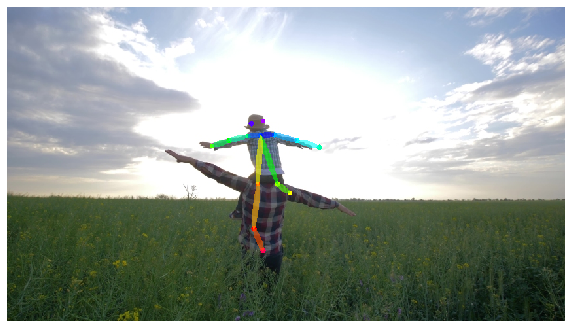

In [37]:
test_image = 'images/weirdos_filtered/1.jpg'

def estimate_plot(filename):
    objtohighlight = part["neck"]
    oriImg = cv2.imread(filename)  # B,G,R order
    candidate, subset = body_estimation(oriImg)
    print(candidate[:,0:2])
    print(subset.shape)
    canvas = copy.deepcopy(oriImg)
    canvas = util.draw_bodypose(canvas, candidate, subset)
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas[:, :, [2, 1, 0]])
    plt.axis('off')
    plt.show()
    
estimate_plot(test_image)